# KDDCup1999

## Import libraries

In [15]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV, LearningCurveDisplay, learning_curve
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay, classification_report
from imblearn.over_sampling import SMOTE

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)
pd.set_option('display.expand_frame_repr', False)

## Import datasets

In [3]:
col_names = ["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins","logged_in",
             "num_compromised","root_shell","su_attempted","num_root","num_file_creations","num_shells","num_access_files","num_outbound_cmds",
             "is_host_login","is_guest_login","count","srv_count","serror_rate","srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
             "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count","dst_host_same_srv_rate","dst_host_diff_srv_rate",
             "dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate","dst_host_rerror_rate",
             "dst_host_srv_rerror_rate"]
label = ["label"]

In [4]:
X_train = pd.read_csv('./data/kddcup/X_train_res.csv', index_col=False)
y_train = pd.read_csv('./data/kddcup/y_train_res.csv', index_col=False)
X_test = pd.read_csv('./data/kddcup/X_test.csv', index_col=False)
y_test = pd.read_csv('./data/kddcup/y_test.csv', index_col=False)

In [5]:
y_train.value_counts()

label
0        2748096
1        2748096
Name: count, dtype: int64

Labels:  
0 = normal  
1 = attack

In [6]:
X_train.shape, X_test.shape

((5496192, 41), (1469530, 41))

## Select features

In [7]:
selected_features = [
    'protocol_type', 'service', 'flag', 'logged_in', 'count',
    'srv_count', 'serror_rate', 'srv_serror_rate', 'same_srv_rate',
    'srv_diff_host_rate', 'dst_host_count', 'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate'
]
X_train_sel = X_train[selected_features]
X_test_sel = X_test[selected_features]

print("Original number of features:", X_train.shape[1])
print("Number of selected features:", X_train_sel.shape[1])
print("Number of training samples:", X_train_sel.shape[0])
print("Number of test samples:", X_test_sel.shape[0])

Original number of features: 41
Number of selected features: 15
Number of training samples: 5496192
Number of test samples: 1469530


## Model training

In [8]:
# Function to print classification reports and plot confusion matrix and ROC curve
def print_reports(clf, X_test, y_test, y_pred, classes, title):
    print(title)
    # print classification report
    print(classification_report(y_test, y_pred))
    
    print()
    
    # plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    print()
    
    # plot ROC curve
    roc_disp = RocCurveDisplay.from_estimator(clf, X_test, y_test)

### Stochastic Gradient Descent

In [11]:
%%time
sgd_clf = SGDClassifier(max_iter=1000)
sgd_clf.fit(X_train, y_train.values.ravel())
sgd_pred = sgd_clf.predict(X_test)

CPU times: user 31.9 s, sys: 1.42 s, total: 33.3 s
Wall time: 33.7 s


SGD Classifier Confusion Matrix
              precision    recall  f1-score   support

           0       0.84      0.86      0.85    291976
           1       0.97      0.96      0.96   1177554

    accuracy                           0.94   1469530
   macro avg       0.90      0.91      0.91   1469530
weighted avg       0.94      0.94      0.94   1469530




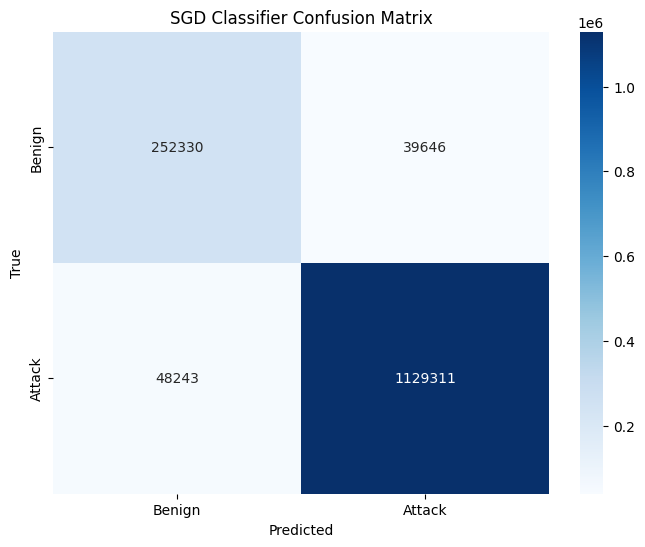

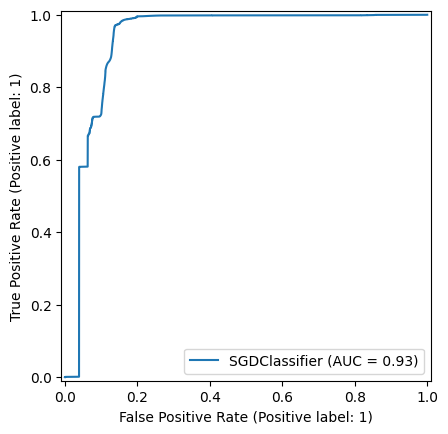

In [12]:
print_reports(sgd_clf, X_test, y_test, sgd_pred, ['Benign', 'Attack'], 'SGD Classifier Confusion Matrix')

### After feature selection and hyperparameter tuning

In [13]:
%%time
clf = SGDClassifier(max_iter=5000, penalty='elasticnet', loss='hinge', alpha=0.0001)
clf.fit(X_train_sel, y_train.values.ravel())
y_pred = clf.predict(X_test_sel)

CPU times: user 49.8 s, sys: 250 ms, total: 50.1 s
Wall time: 50.6 s


SGD Confusion Matrix w/ 15 best features and hyperparameter tuning
              precision    recall  f1-score   support

           0       0.96      1.00      0.98    291976
           1       1.00      0.99      0.99   1177554

    accuracy                           0.99   1469530
   macro avg       0.98      0.99      0.99   1469530
weighted avg       0.99      0.99      0.99   1469530




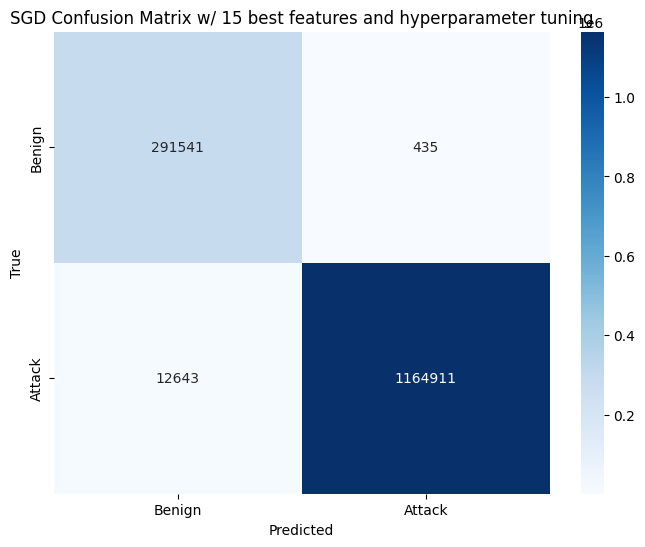

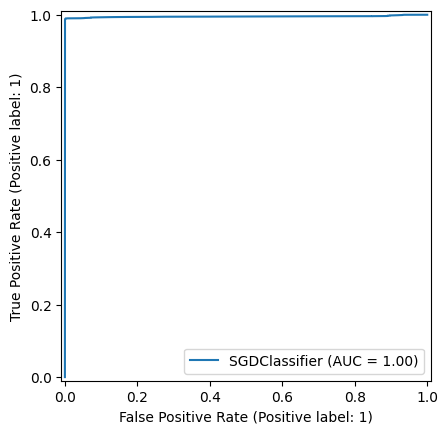

In [14]:
print_reports(clf, X_test_sel, y_test, y_pred, ['Benign', 'Attack'], 'SGD Confusion Matrix w/ 15 best features and hyperparameter tuning')

/home/c3rb/ml/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
2 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/home/c3rb/ml/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/c3rb/ml/venv/lib/python3.12/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/c3rb/ml/venv/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py", lin

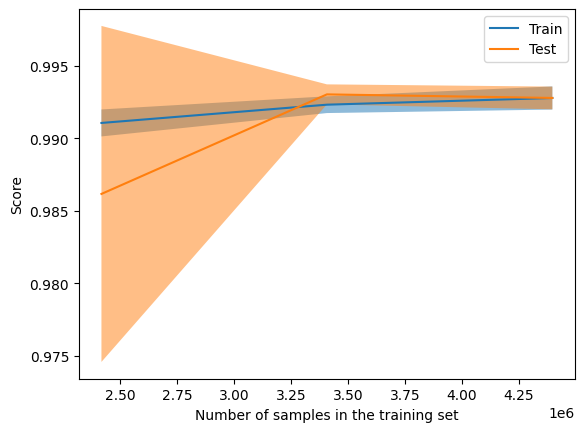

In [17]:
train_sizes, train_scores, test_scores = learning_curve(clf, X_train_sel, y_train.values.ravel())
display = LearningCurveDisplay(train_sizes=train_sizes, train_scores=train_scores, test_scores=test_scores, score_name="Score")
display.plot()
plt.show()